In [34]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import os
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
#Set up data with following aspect: Date, Close_price, Open_price, High_price, Low_price, Trading volume
#Case #1 : Apple daily price data 
#Case #2 :
data = pd.read_csv("AAPL_price.csv")
data.head()

,Date,Close,Open,High,Low,Volume
0,1980-12-12,0.13,0.13,0.13,0.13,469030000.0
1,1980-12-15,0.12,0.12,0.12,0.12,175880000.0
2,1980-12-16,0.11,0.11,0.11,0.11,105730000.0
3,1980-12-17,0.12,0.12,0.12,0.12,86440000.0
4,1980-12-18,0.12,0.12,0.12,0.12,73450000.0


# Data Cleaning

In [3]:

# Check the percentage of the missing data from the given dataset
# If missing data is less than 5% --> Remove the missing values
# Else --> Impute missing data with midpoint of nearby data
missing_count = data.isnull().sum() / data.count()
if missing_count.Close < 0.05: 
	data.dropna(inplace=True)
else:
	data = data.interpolate() # Takes the midpoint between the points

# Ensure there are no duplicates
data.drop_duplicates(subset='Date', inplace=True)

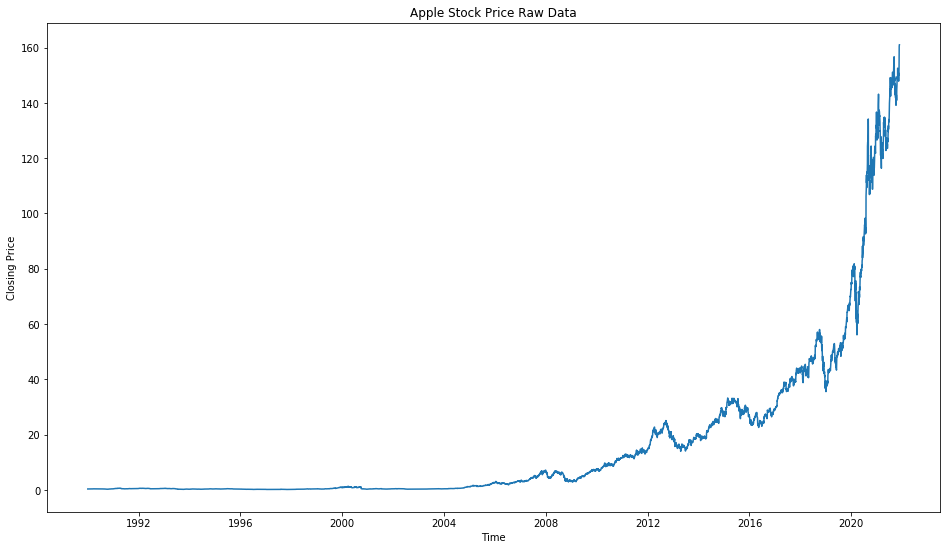

In [4]:
# Test (Deal with data after 1990 ~ ) (Not confirmed)

data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data = data.loc[data['year'] >= 1990]

# Graph raw data
plt.figure(figsize=(16, 9))
plt.plot(data['Date'], data['Close'])
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Apple Stock Price Raw Data')
plt.show()
# plt.savefig('raw_data.png')

# Noise Filtering

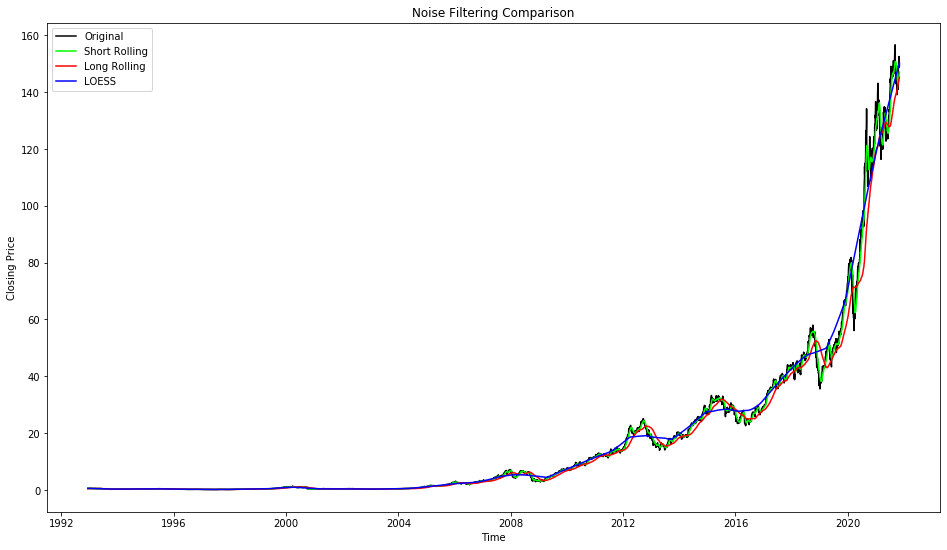

In [24]:
# 1. Rolling mean
short_data = data
short_data['short_rolling'] = data['Close'].shift(-1).rolling(window=20).mean()
short_data.dropna(inplace=True)

long_data = data
long_data['long_rolling'] = data['Close'].shift(-1).rolling(window=100).mean()
long_data.dropna(inplace=True)

plt.figure(figsize=(16, 9))
plt.plot(data['Date'], data['Close'], color='black', linewidth=1.5)	# Original data
plt.plot(data['Date'], short_data['short_rolling'], color='lime', label='20-days SMA')
plt.plot(data['Date'], long_data['long_rolling'], color='red', label='100-days SMA')

# 2. LOESS
filtered = lowess(data['Close'], data['Date'], frac=0.05)
plt.plot(data['Date'], filtered[:, 1], 'r-', color='blue')

plt.legend(['Original', 'Short Rolling', 'Long Rolling', 'LOESS'])
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Noise Filtering Comparison')
plt.show()
# plt.savefig('noise_filtering.png')

# Machine Learning: Regression Models

## Linear Regression - Short Rolling

0.9983717934248948
0.9939873209572792


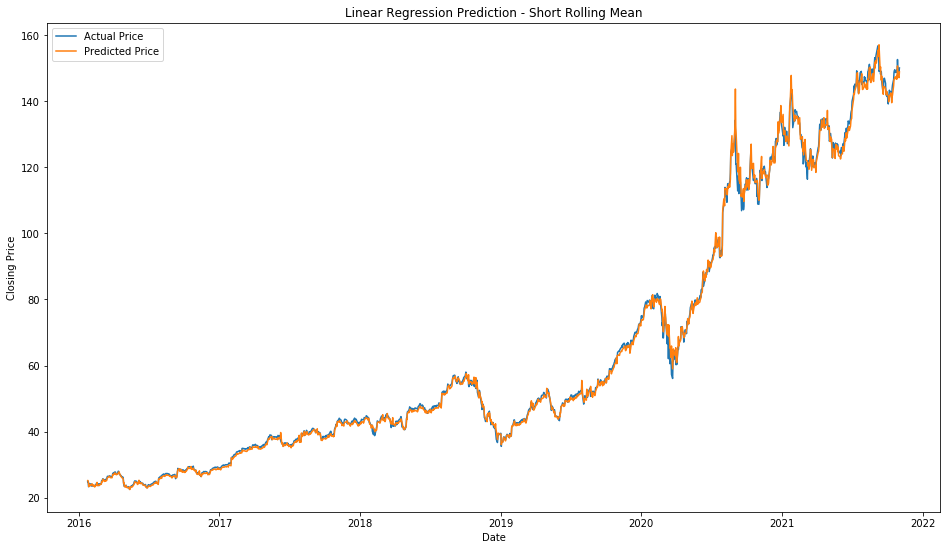

In [25]:
X = data[['Open', 'High', 'Low', 'Volume']]
y_short = short_data['short_rolling']
t = int(0.8*len(data))
X_train = X[:t]
X_test = X[t:]
y_short_train = y_short[:t]
y_short_test = y_short[t:]

lin_model = make_pipeline(
    MinMaxScaler(),
    LinearRegression()
)
lin_model.fit(X_train, y_short_train)
predictions = lin_model.predict(X_test) # Predict a model
print(lin_model.score(X_train, y_short_train)) 
print(lin_model.score(X_test, y_short_test)) 

# Making DataFrame for the predictions & Joining
predictions = pd.DataFrame(predictions, index=y_short_test.index, columns=['Linear_pred_short'])
join_pred = data.join(predictions, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['Linear_pred_short'],  label='Predicted Price')
plt.title('Linear Regression Prediction - Short Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

## Linear Regression - Long Rolling

0.9874019178755602
0.9574186823149864


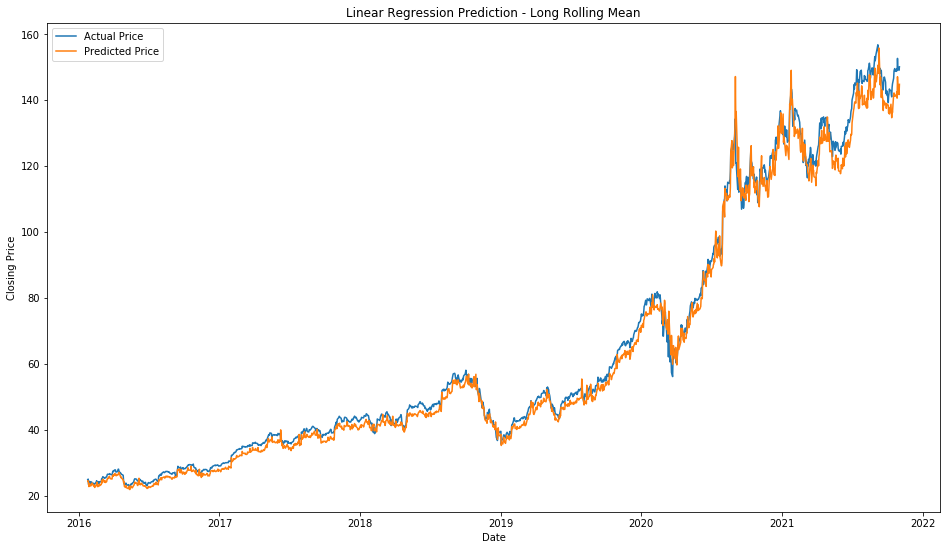

In [26]:
X = data[['Open', 'High', 'Low', 'Volume']]
y_long = long_data['long_rolling']
t = int(0.8*len(data))
X_train = X[:t]
X_test = X[t:]
y_long_train = y_long[:t]
y_long_test = y_long[t:]

lin_model = make_pipeline(
    MinMaxScaler(),
    LinearRegression()
)
lin_model.fit(X_train, y_long_train)
predictions = lin_model.predict(X_test) # Predict a model
print(lin_model.score(X_train, y_long_train)) 
print(lin_model.score(X_test, y_long_test)) 

# Making DataFrame for the predictions & Joining
predictions = pd.DataFrame(predictions, index=y_long_test.index, columns=['Linear_pred_long'])
join_pred = data.join(predictions, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['Linear_pred_long'],  label='Predicted Price')
plt.title('Linear Regression Prediction - Long Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

## K-nearest Neighbour Regression - Short Rolling

0.9988271705154744
-0.7056563761095811


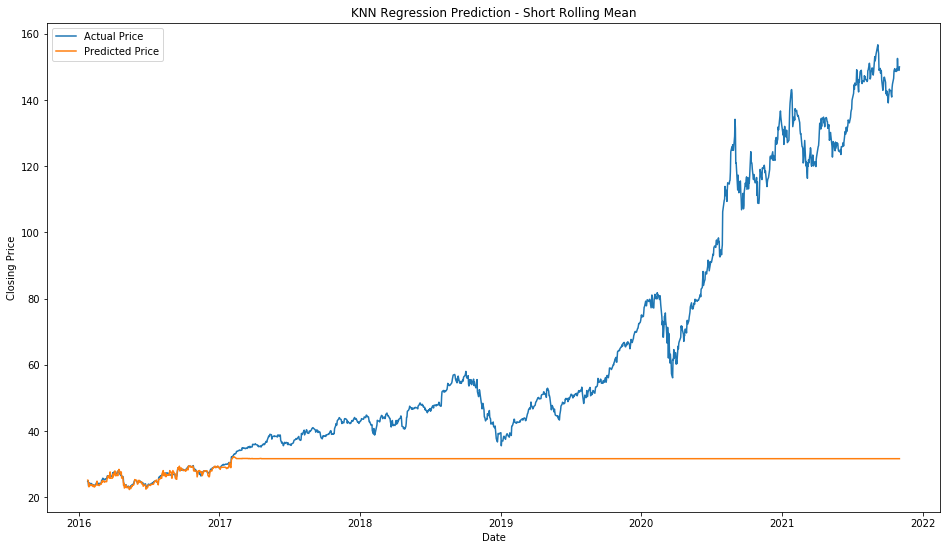

In [29]:
# Training & Test data defined above already
knn_model = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=5)
)
knn_model.fit(X_train, y_short_train)
knn_pred = knn_model.predict(X_test) # Predict a model
print(knn_model.score(X_train, y_short_train)) 
print(knn_model.score(X_test, y_short_test)) 

# Making DataFrame for the predictions & Joining
knn_pred = pd.DataFrame(knn_pred, index=y_short_test.index, columns=['Knn_pred_short'])
join_pred = data.join(knn_pred, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['Knn_pred_short'], label='Predicted Price')
plt.title('KNN Regression Prediction - Short Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

## K-nearest Neighbour Regression - Long Rolling

0.9932700362372733
-0.7301688154432773


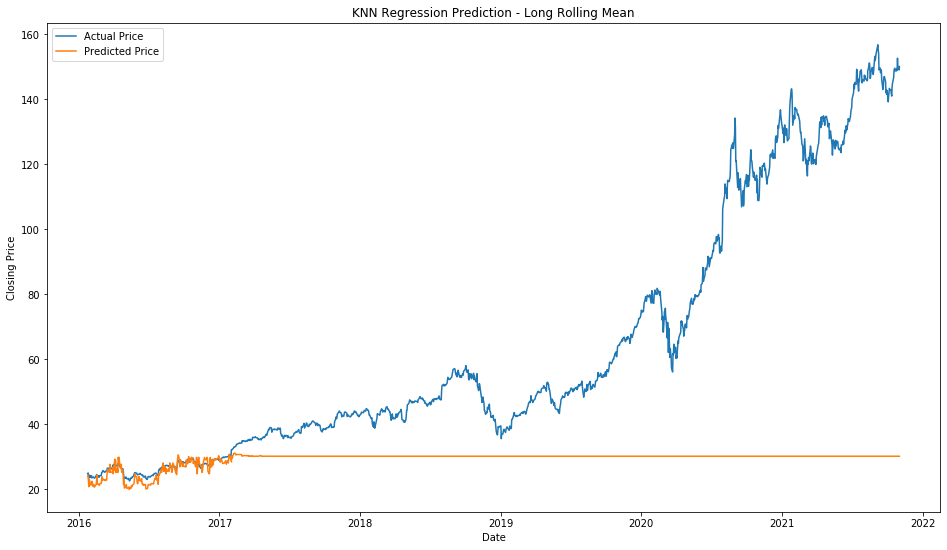

In [30]:
# Training & Test data defined above already
knn_model = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=5)
)
knn_model.fit(X_train, y_long_train)
knn_pred = knn_model.predict(X_test) # Predict a model
print(knn_model.score(X_train, y_long_train)) 
print(knn_model.score(X_test, y_long_test)) 

# Making DataFrame for the predictions & Joining
knn_pred = pd.DataFrame(knn_pred, index=y_long_test.index, columns=['Knn_pred_long'])
join_pred = data.join(knn_pred, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['Knn_pred_long'], label='Predicted Price')
plt.title('KNN Regression Prediction - Long Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

## Random Forest Regression - Best Parameters

In [38]:
# Short Rolling
grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_short_train)
    test_scores.append(rf_model.score(X_test, y_short_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

# Long Rolling
grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_long_train)
    test_scores.append(rf_model.score(X_test, y_long_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

-0.6948381309794909 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}
-0.7081350872840535 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}


## Random Forest Regression - Short Rolling

0.9986369054874186
-0.6981803852251021


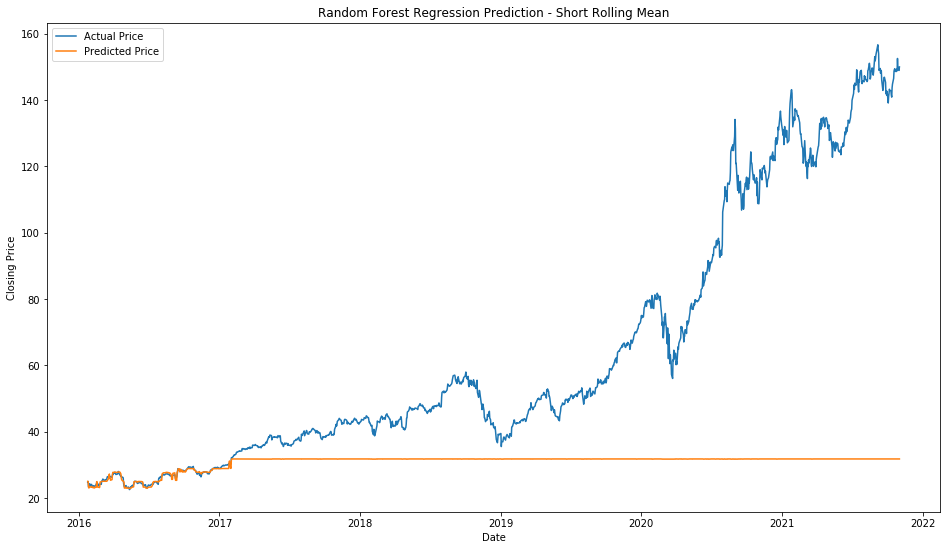

In [39]:
# Training & Test data defined above already
rf_model = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
)
rf_model.fit(X_train, y_short_train)
rf_pred = rf_model.predict(X_test) # Predict a model
print(rf_model.score(X_train, y_short_train)) # Short - 0.997828, Long - 0.987426
print(rf_model.score(X_test, y_short_test)) # Short - 0.992788, Long - 0.966242

# Making DataFrame for the predictions & Joining
rf_pred = pd.DataFrame(rf_pred, index=y_short_test.index, columns=['rf_pred_short'])
join_pred = data.join(rf_pred, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['rf_pred_short'], label='Predicted Price')
plt.title('Random Forest Regression Prediction - Short Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

## Random Forest Regression - Long Rolling

0.9916361960458834
-0.7138105321798438


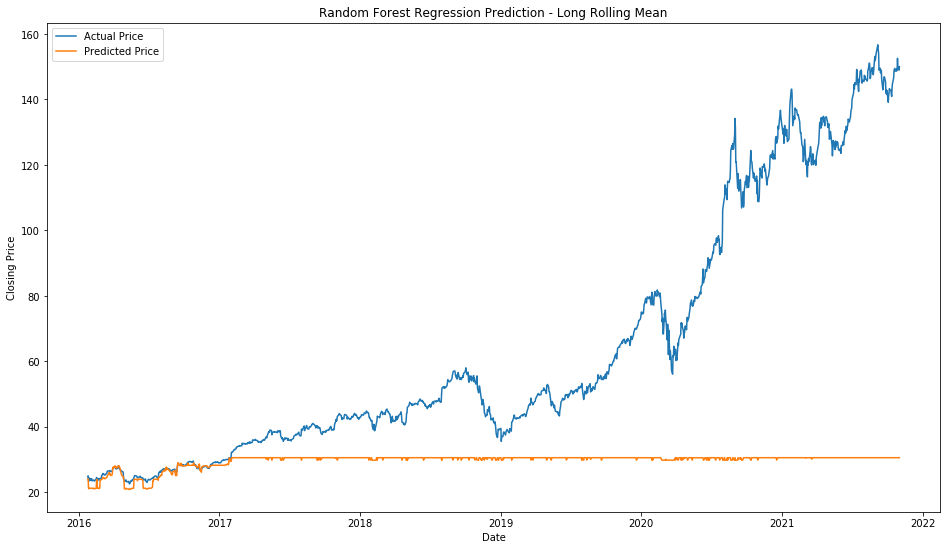

In [40]:
# Training & Test data defined above already
rf_model = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
)
rf_model.fit(X_train, y_long_train)
rf_pred = rf_model.predict(X_test) # Predict a model
print(rf_model.score(X_train, y_long_train)) # Short - 0.997828, Long - 0.987426
print(rf_model.score(X_test, y_long_test)) # Short - 0.992788, Long - 0.966242

# Making DataFrame for the predictions & Joining
rf_pred = pd.DataFrame(rf_pred, index=y_long_test.index, columns=['rf_pred_long'])
join_pred = data.join(rf_pred, how='inner')

plt.figure(figsize=(16, 9))
plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
plt.plot(join_pred['Date'], join_pred['rf_pred_long'], label='Predicted Price')
plt.title('Random Forest Regression Prediction - Long Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()

# Deep Learning - LSTM

## Data Pre-processing

In [60]:
closePriceShort = short_data['short_rolling'].astype("float32")
closePriceLong = long_data["long_rolling"].astype("float32")
train_Short = closePriceShort[0:int(len(closePriceShort)*0.8)]
train_Long = closePriceLong[0:int(len(closePriceLong)*0.8)]


In [61]:
# LSTM Data normalization
#We have to sacle our data for optimal performance
sc = MinMaxScaler(feature_range = (-1,1))
training_set_scaled = sc.fit(train_Short.values.reshape(-1,1))
closePrice = sc.transform(closePriceShort.values.reshape(-1,1))





In [62]:
'''
Our train data will have as features the look back values, which are the lag values noted as ‘lb’.
For this example, we set the lb equal to 10. Notice that we scale the data on the “train” dataset
using the MinMaxScaler() from scikit-learn. Finally, for this example, we keep as train dataset
the first 90% of the observations and as a test dataset the rest 10%
'''
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(closePrice,lb)
X,y = processData(closePrice,lb)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])


5812 10
1454 10
5812
1454


In [48]:
#Need to install Tensorflow
#pip install --upgrade tensorflow
#pip install keras
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1,))
model.compile(optimizer='adam',loss='mse', metrics=('acc'))

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),shuffle=True)
model.summary() 


Epoch 1/100
182/182 [==============================] - 5s 18ms/step - loss: 0.0107 - acc: 1.7206e-04 - val_loss: 1.2763 - val_acc: 0.0000e+00
Epoch 2/100
182/182 [==============================] - 3s 16ms/step - loss: 1.0728e-04 - acc: 1.7206e-04 - val_loss: 1.2539 - val_acc: 0.0000e+00
Epoch 3/100
182/182 [==============================] - 3s 17ms/step - loss: 1.0444e-04 - acc: 1.7206e-04 - val_loss: 1.0199 - val_acc: 0.0000e+00
Epoch 4/100
182/182 [==============================] - 3s 17ms/step - loss: 1.0435e-04 - acc: 1.7206e-04 - val_loss: 0.8981 - val_acc: 0.0000e+00
Epoch 5/100
182/182 [==============================] - 3s 17ms/step - loss: 9.7431e-05 - acc: 1.7206e-04 - val_loss: 0.6874 - val_acc: 0.0000e+00
Epoch 6/100
182/182 [==============================] - 3s 17ms/step - loss: 9.9249e-05 - acc: 1.7206e-04 - val_loss: 0.6093 - val_acc: 0.0000e+00
Epoch 7/100
182/182 [==============================] - 3s 17ms/step - loss: 8.9471e-05 - acc: 1.7206e-04 - val_loss: 0.3827 - va

Epoch 57/100
182/182 [==============================] - 3s 16ms/step - loss: 8.2794e-06 - acc: 1.7206e-04 - val_loss: 0.1587 - val_acc: 0.0000e+00
Epoch 58/100
182/182 [==============================] - 3s 16ms/step - loss: 8.8295e-06 - acc: 1.7206e-04 - val_loss: 0.1717 - val_acc: 0.0000e+00
Epoch 59/100
182/182 [==============================] - 3s 16ms/step - loss: 1.3108e-05 - acc: 1.7206e-04 - val_loss: 0.1390 - val_acc: 0.0000e+00
Epoch 60/100
182/182 [==============================] - 3s 16ms/step - loss: 1.9927e-05 - acc: 1.7206e-04 - val_loss: 0.1646 - val_acc: 0.0000e+00
Epoch 61/100
182/182 [==============================] - 3s 16ms/step - loss: 9.5756e-06 - acc: 1.7206e-04 - val_loss: 0.0950 - val_acc: 0.0000e+00
Epoch 62/100
182/182 [==============================] - 3s 16ms/step - loss: 6.9227e-06 - acc: 1.7206e-04 - val_loss: 0.1937 - val_acc: 0.0000e+00
Epoch 63/100
182/182 [==============================] - 3s 16ms/step - loss: 8.8903e-06 - acc: 1.7206e-04 - val_loss: 

Text(0.5, 1.0, 'Train Dataset')

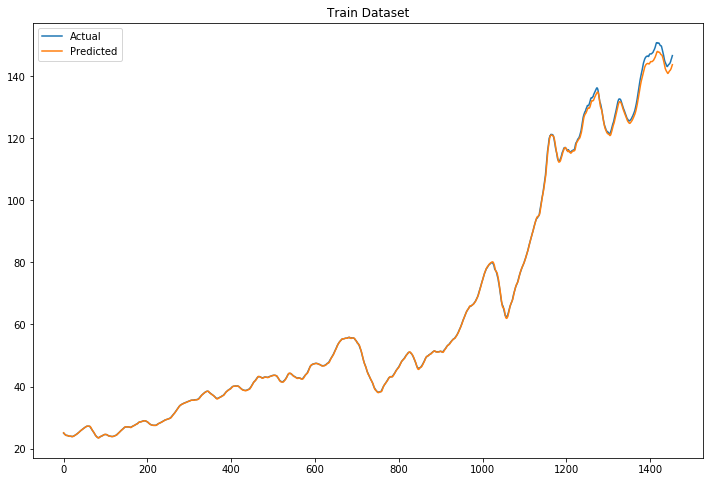

In [64]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_test)

plt.plot(sc.inverse_transform(y_test.reshape(-1,1)),label="Actual")
plt.plot(sc.inverse_transform(Xt),label="Predicted")
plt.legend()
plt.title("Train Dataset")

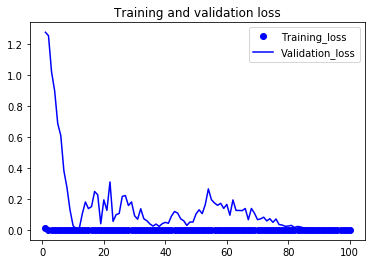

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001720578147796914, 0.0001

In [57]:
#Loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training_loss")
plt.plot(epochs, val_loss, "b", label = "Validation_loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# print("The accuracy is {}".format(val_accuracy))
print(history.history.keys())
print(history.history["acc"])